# Bu çalışma robot hemşire için yapılmıştır.

Veri olarak göğüs bölgesinin X-RAY görüntüleri kullanılmış, bu veriler aracılığıyla tüberküloz ve zatüre hastalığı tespit edilmeye çalışılmıştır.

<h5> Zatürre(Pneumonia) hastalığının tespiti için kullanılan veri seti https://data.mendeley.com/datasets/rscbjbr9sj/2 'den erişilebilir.  </h5>

<h5> Tüberküloz(TB) hastalığının tespiti için kullanılan veri seti https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4256233/ 'den erişilebilir. Montgomery ABD'de ve Shenzhen Çin'deki bir hastanenin X-ray görüntülerinin yer aldığı veri setleridir. </h5>




In [6]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
import tensorflow as tf

from keras.utils import to_categorical
import time
from sklearn.model_selection import train_test_split
seed = 333
np.random.seed(seed)


C:\Users\AsusNb\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\AsusNb\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\AsusNb\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\AsusNb\AppData\Roaming\Python\Python37\s

In [7]:

import os
directory = "C:/Users/AsusNb/Desktop/robothemsire/input/chest-xray-pneumonia/chest_xray/chest_xray"
print(os.listdir(directory))



['.DS_Store', 'test', 'train', 'val']


In [8]:
img_dir = "C:/Users/AsusNb/Desktop/robothemsire/input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles"
data_dir2 = "C:/Users/AsusNb/Desktop/robothemsire/input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/ClinicalReadings"
img_dir2 = "C:/Users/AsusNb/Desktop/robothemsire/input/chest-xray-pneumonia/chest_xray/chest_xray"
#img_dir Çin'deki hastanenin verilerinin bulunduğu path'ı
#img_dir2 Zatürre hastalığı için oluşturulan verilerin bulunduğu path'ı

In [9]:
def load_data(img_dir,data_dir2,img_dir2):
    X = []
    y = []
    labels = []
    idx = 0
    for i,folder_name in enumerate(os.listdir(img_dir)):
        if folder_name in ( "CXR_png"):
            for file_name in tqdm(os.listdir(f'{img_dir}/{folder_name}')):
                if file_name.endswith('png'):
                    #print(file_name)
                    f = open('C:/Users/AsusNb/Desktop/robothemsire/input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/ClinicalReadings/'+file_name[:-4]+'.txt', 'r')
                    file_contents = f.read()
                    file_con_list = file_contents.split("\n")
                    if file_con_list[-1]=="":
                        file_con_list = file_con_list[-2].lower()
                    else:
                        file_con_list = file_con_list[-1]
                    if "TB" in file_con_list or "tuberculosis" in file_con_list:
                        file_con_list = "TB"
                    elif "normal" in file_con_list:
                        file_con_list = "normal"
                    elif "pneumonia" in file_con_list:
                        file_con_list = "pneumonia"
                    #print (file_con_list)
                    if file_con_list not in labels:
                        labels.append(file_con_list)
                    im = cv2.imread(f'{img_dir}/{folder_name}/{file_name}')
                    if im is not None:
                        im = cv2.resize(im, (100, 100))
                        X.append(im)
                        y.append(labels.index(file_con_list))
                        
    for i,folder_name in enumerate(['test', 'train', 'val']):
        #here we get validation and train
        for j,folder_name1 in enumerate(os.listdir(os.path.join(img_dir2,folder_name))):
            if folder_name1 in ( "PNEUMONIA","NORMAL"):
                if folder_name1.lower() not in labels:
                    labels.append(folder_name1.lower())
                for file_name in tqdm(os.listdir(f'{img_dir2}/{folder_name}/{folder_name1}')):
                    if file_name.endswith('jpeg'):
                        im = cv2.imread(f'{img_dir2}/{folder_name}/{folder_name1}/{file_name}')
                    if im is not None:
                        im = cv2.resize(im, (100, 100))
                        X.append(im)
                        y.append(labels.index(folder_name1.lower()))

    
    X = np.asarray(X)
    y = np.asarray(y)
    labels = np.asarray(labels)
    return X,y,labels

def load_data1(img_dir2):
    X = []
    y = []
    labels = []
    idx = 2
    for i,folder_name in enumerate(os.listdir(img_dir2)):
        #here we get validation and train
        for j,folder_name1 in enumerate(os.listdir(os.path.join(img_dir2,folder_name))):
            if folder_name1 in ( "humans"):
                if folder_name1 not in labels:
                    labels.append(folder_name)
                for file_name in tqdm(os.listdir(f'{img_dir2}/{folder_name}/{folder_name1}')):
                    if file_name.endswith('png'):
                        im = cv2.imread(f'{img_dir2}/{folder_name}/{folder_name1}/{file_name}')
                    if im is not None:
                        im = cv2.resize(im, (100, 100))
                        X.append(im)
                        y.append(idx)
            
    
    X = np.asarray(X)
    y = np.asarray(y)
    labels = np.asarray(labels)
    return X,y,labels

<h2> Dataset yükleme </h2>


In [10]:
X,y,labels = load_data(img_dir,data_dir2,img_dir2)
#X1,y1,labels1 = load_data1(img_dir2)
#X,y,labels = X2,y2,labels1+labels2

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 40.45it/s]


In [7]:
y = y.reshape(-1,1)



In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
#Test ve Train verisi olarak ayırıyoruz.

In [12]:
train_img = X_train
train_labels = y_train
test_img = X_test
test_labels = y_test
train_img.shape, train_labels.shape, test_img.shape, test_labels.shape

((5218, 100, 100, 3), (5218,), (1305, 100, 100, 3), (1305,))

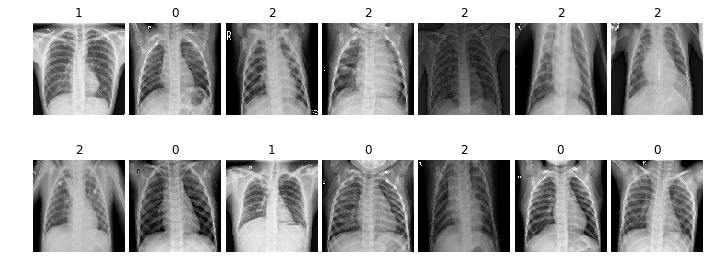

['normal' 'TB' 'pneumonia']


In [13]:
#Random örnekler
rand_14 = np.random.randint(0, train_img.shape[0],14)
sample_img = train_img[rand_14]
sample_labels = train_labels[rand_14]
num_rows, num_cols = 2, 7
f, ax = plt.subplots(num_rows, num_cols, figsize=(12,5),gridspec_kw={'wspace':0.05, 'hspace':0.02})
for r in range(num_rows):
    for c in range(num_cols):
        image_index = r * 7 + c
        ax[r,c].axis("off")
        ax[r,c].imshow(sample_img[image_index])
        ax[r,c].set_title('%s' % sample_labels[image_index])
plt.show()
plt.close()
print(labels)

In [11]:
#one-hot-encode the labels
num_classes = len(labels)
train_labels_cat = to_categorical(train_labels,num_classes)
test_labels_cat = to_categorical(test_labels,num_classes)
train_labels_cat.shape, test_labels_cat.shape

((5217, 3), (1305, 3))

In [12]:
# re-shape the images data
train_data = train_img
test_data = test_img
train_data.shape, test_data.shape

((5217, 100, 100, 3), (1305, 100, 100, 3))

In [13]:
# shuffle the training dataset & set aside val_perc % of rows as validation data
for _ in range(5): 
    indexes = np.random.permutation(len(train_data))

# randomly sorted!
train_data = train_data[indexes]
train_labels_cat = train_labels_cat[indexes]

# now we will set-aside val_perc% of the train_data/labels as cross-validation sets
val_perc = 0.10
val_count = int(val_perc * len(train_data))
print(val_count)

# first pick validation set
val_data = train_data[:val_count,:]
val_labels_cat = train_labels_cat[:val_count,:]

# leave rest in training set
train_data2 = train_data[val_count:,:]
train_labels_cat2 = train_labels_cat[val_count:,:]

train_data2.shape, train_labels_cat2.shape, val_data.shape, val_labels_cat.shape, test_data.shape, test_labels_cat.shape

521


((4696, 100, 100, 3),
 (4696, 3),
 (521, 100, 100, 3),
 (521, 3),
 (1305, 100, 100, 3),
 (1305, 3))

In [15]:
# a utility function that plots the losses and accuracies for training & validation sets across our epochs
def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['acc'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['acc']
    val_acc_vals = history['val_acc']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals

In [15]:
def print_time_taken(start_time, end_time):
    secs_elapsed = end_time - start_time
    
    SECS_PER_MIN = 60
    SECS_PER_HR  = 60 * SECS_PER_MIN
    
    hrs_elapsed, secs_elapsed = divmod(secs_elapsed, SECS_PER_HR)
    mins_elapsed, secs_elapsed = divmod(secs_elapsed, SECS_PER_MIN)
    
    if hrs_elapsed > 0:
        print('Time taken: %d hrs %d mins %d secs' % (hrs_elapsed, mins_elapsed, secs_elapsed))
    elif mins_elapsed > 0:
        print('Time taken: %d mins %d secs' % (mins_elapsed, secs_elapsed))
    elif secs_elapsed > 1:
        print('Time taken: %d secs' % (secs_elapsed))
    else:
        print('Time taken - less than 1 sec')

In [16]:
def get_commonname(idx):
    sciname = labels[idx]
    return sciname

<h2> Eğitme </h2>

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


import numpy as np
from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,Activation,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.datasets import mnist
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from PIL import Image

In [17]:
#data augmentation
datagen = ImageDataGenerator(
        rotation_range=30,
        zoom_range = 0.25,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [18]:
#model 1
model = Sequential()

model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (100, 100, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))


model.add(Conv2D(256, kernel_size = 4, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

# use adam optimizer and categorical cross entropy cost
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


NameError: name 'num_classes' is not defined

In [20]:
# after each epoch decrease learning rate by 0.95
annealer = LearningRateScheduler(lambda x: 2e-3 * 0.55 ** x)

# train
epochs = 50
j=0
start_time = time.time()
history = model.fit_generator(datagen.flow(train_data2, train_labels_cat2, batch_size=64),epochs = epochs, steps_per_epoch = train_data2.shape[0]/64,validation_data = (val_data, val_labels_cat), callbacks=[annealer], verbose=1)
end_time = time.time()
print_time_taken(start_time, end_time)


print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(j+1,epochs,history.history['acc'][epochs-1],history.history['val_acc'][epochs-1]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
74/73 [==============================] - ETA: 14:40 - loss: 1.9347 - acc: 0.23 - ETA: 10:48 - loss: 1.5588 - acc: 0.41 - ETA: 9:25 - loss: 1.3586 - acc: 0.5208 - ETA: 8:43 - loss: 1.6798 - acc: 0.539 - ETA: 8:16 - loss: 1.5843 - acc: 0.578 - ETA: 7:54 - loss: 1.6014 - acc: 0.565 - ETA: 7:02 - loss: 1.5329 - acc: 0.567 - ETA: 6:53 - loss: 1.5598 - acc: 0.572 - ETA: 6:47 - loss: 1.4714 - acc: 0.596 - ETA: 6:39 - loss: 1.4405 - acc: 0.606 - ETA: 6:32 - loss: 1.4068 - acc: 0.614 - ETA: 6:26 - loss: 1.4013 - acc: 0.620 - ETA: 6:20 - loss: 1.4017 - acc: 0.626 - ETA: 6:13 - loss: 1.3896 - acc: 0.634 - ETA: 6:07 - loss: 1.3482 - acc: 0.646 - ETA: 6:01 - loss: 1.3607 - acc: 0.647 - ETA: 5:55 - loss: 1.3450 - acc: 0.652 - ETA: 5:48 - loss: 1.3657 - acc: 0.653 - ETA: 5:41 - loss: 1.3216 - acc: 0.663 - ETA: 5:35 - loss: 1.3286 - acc: 0.669 - ETA: 5:29 - loss: 1.3586 - acc: 0.669 - ETA: 5:22 - l

74/73 [==============================] - ETA: 7:16 - loss: 0.2285 - acc: 0.906 - ETA: 7:15 - loss: 0.2947 - acc: 0.882 - ETA: 7:14 - loss: 0.3794 - acc: 0.869 - ETA: 7:05 - loss: 0.3317 - acc: 0.882 - ETA: 6:58 - loss: 0.3358 - acc: 0.871 - ETA: 6:51 - loss: 0.3335 - acc: 0.864 - ETA: 6:46 - loss: 0.3656 - acc: 0.859 - ETA: 6:44 - loss: 0.4024 - acc: 0.845 - ETA: 6:37 - loss: 0.3821 - acc: 0.852 - ETA: 6:30 - loss: 0.3680 - acc: 0.856 - ETA: 6:23 - loss: 0.3561 - acc: 0.858 - ETA: 6:17 - loss: 0.3678 - acc: 0.851 - ETA: 6:11 - loss: 0.3598 - acc: 0.855 - ETA: 6:05 - loss: 0.3519 - acc: 0.858 - ETA: 5:58 - loss: 0.3453 - acc: 0.859 - ETA: 5:52 - loss: 0.3434 - acc: 0.860 - ETA: 5:45 - loss: 0.3686 - acc: 0.856 - ETA: 5:39 - loss: 0.3686 - acc: 0.857 - ETA: 5:33 - loss: 0.3780 - acc: 0.853 - ETA: 5:27 - loss: 0.3869 - acc: 0.851 - ETA: 5:20 - loss: 0.3897 - acc: 0.849 - ETA: 5:14 - loss: 0.3919 - acc: 0.848 - ETA: 5:08 - loss: 0.3920 - acc: 0.846 - ETA: 5:02 - loss: 0.3853 - acc: 0.849 -

74/73 [==============================] - ETA: 7:23 - loss: 0.2481 - acc: 0.890 - ETA: 7:16 - loss: 0.2486 - acc: 0.875 - ETA: 7:14 - loss: 0.2663 - acc: 0.859 - ETA: 7:05 - loss: 0.3336 - acc: 0.847 - ETA: 6:58 - loss: 0.3160 - acc: 0.853 - ETA: 6:52 - loss: 0.3031 - acc: 0.864 - ETA: 6:46 - loss: 0.2924 - acc: 0.872 - ETA: 6:40 - loss: 0.3058 - acc: 0.869 - ETA: 6:34 - loss: 0.2989 - acc: 0.873 - ETA: 6:27 - loss: 0.3021 - acc: 0.871 - ETA: 6:21 - loss: 0.3017 - acc: 0.876 - ETA: 6:15 - loss: 0.2971 - acc: 0.877 - ETA: 6:09 - loss: 0.2914 - acc: 0.877 - ETA: 6:03 - loss: 0.2934 - acc: 0.876 - ETA: 5:56 - loss: 0.2967 - acc: 0.875 - ETA: 5:50 - loss: 0.2994 - acc: 0.877 - ETA: 5:44 - loss: 0.3036 - acc: 0.876 - ETA: 5:37 - loss: 0.2999 - acc: 0.877 - ETA: 5:31 - loss: 0.3144 - acc: 0.870 - ETA: 5:25 - loss: 0.3146 - acc: 0.868 - ETA: 5:19 - loss: 0.3138 - acc: 0.868 - ETA: 5:13 - loss: 0.3123 - acc: 0.867 - ETA: 5:07 - loss: 0.3110 - acc: 0.869 - ETA: 5:01 - loss: 0.3111 - acc: 0.869 -

74/73 [==============================] - ETA: 7:28 - loss: 0.3058 - acc: 0.906 - ETA: 7:20 - loss: 0.2919 - acc: 0.898 - ETA: 7:18 - loss: 0.2758 - acc: 0.901 - ETA: 7:08 - loss: 0.2600 - acc: 0.902 - ETA: 7:01 - loss: 0.2711 - acc: 0.893 - ETA: 6:54 - loss: 0.2550 - acc: 0.895 - ETA: 6:48 - loss: 0.2513 - acc: 0.901 - ETA: 6:42 - loss: 0.2495 - acc: 0.904 - ETA: 6:35 - loss: 0.2469 - acc: 0.902 - ETA: 6:29 - loss: 0.2447 - acc: 0.904 - ETA: 6:23 - loss: 0.2655 - acc: 0.896 - ETA: 6:16 - loss: 0.2771 - acc: 0.891 - ETA: 6:09 - loss: 0.2780 - acc: 0.888 - ETA: 6:03 - loss: 0.2802 - acc: 0.886 - ETA: 5:57 - loss: 0.2832 - acc: 0.886 - ETA: 5:51 - loss: 0.2850 - acc: 0.886 - ETA: 5:44 - loss: 0.2883 - acc: 0.884 - ETA: 5:38 - loss: 0.2918 - acc: 0.886 - ETA: 5:32 - loss: 0.2933 - acc: 0.887 - ETA: 5:26 - loss: 0.2939 - acc: 0.885 - ETA: 5:21 - loss: 0.2926 - acc: 0.884 - ETA: 5:15 - loss: 0.2918 - acc: 0.887 - ETA: 5:09 - loss: 0.2947 - acc: 0.885 - ETA: 5:03 - loss: 0.2975 - acc: 0.883 -

74/73 [==============================] - ETA: 7:27 - loss: 0.2075 - acc: 0.890 - ETA: 7:27 - loss: 0.2527 - acc: 0.898 - ETA: 7:17 - loss: 0.2555 - acc: 0.901 - ETA: 7:07 - loss: 0.2737 - acc: 0.906 - ETA: 7:00 - loss: 0.2664 - acc: 0.909 - ETA: 6:53 - loss: 0.2850 - acc: 0.893 - ETA: 6:48 - loss: 0.2905 - acc: 0.892 - ETA: 6:41 - loss: 0.2950 - acc: 0.888 - ETA: 6:34 - loss: 0.3127 - acc: 0.881 - ETA: 6:28 - loss: 0.3098 - acc: 0.884 - ETA: 6:21 - loss: 0.3207 - acc: 0.886 - ETA: 6:16 - loss: 0.3276 - acc: 0.880 - ETA: 6:10 - loss: 0.3313 - acc: 0.878 - ETA: 6:04 - loss: 0.3545 - acc: 0.876 - ETA: 5:58 - loss: 0.3527 - acc: 0.875 - ETA: 5:52 - loss: 0.3478 - acc: 0.876 - ETA: 5:46 - loss: 0.3555 - acc: 0.875 - ETA: 5:40 - loss: 0.3480 - acc: 0.875 - ETA: 5:33 - loss: 0.3448 - acc: 0.875 - ETA: 5:27 - loss: 0.3486 - acc: 0.876 - ETA: 5:21 - loss: 0.3446 - acc: 0.876 - ETA: 5:15 - loss: 0.3439 - acc: 0.876 - ETA: 5:09 - loss: 0.3415 - acc: 0.875 - ETA: 5:03 - loss: 0.3378 - acc: 0.874 -

74/73 [==============================] - ETA: 7:34 - loss: 0.3215 - acc: 0.890 - ETA: 7:22 - loss: 0.4606 - acc: 0.859 - ETA: 7:15 - loss: 0.4831 - acc: 0.843 - ETA: 7:09 - loss: 0.4494 - acc: 0.855 - ETA: 7:04 - loss: 0.4121 - acc: 0.868 - ETA: 6:57 - loss: 0.3972 - acc: 0.867 - ETA: 6:52 - loss: 0.3887 - acc: 0.875 - ETA: 6:44 - loss: 0.3628 - acc: 0.880 - ETA: 6:38 - loss: 0.3380 - acc: 0.885 - ETA: 6:32 - loss: 0.3447 - acc: 0.876 - ETA: 6:25 - loss: 0.3488 - acc: 0.877 - ETA: 6:18 - loss: 0.3591 - acc: 0.871 - ETA: 6:13 - loss: 0.3680 - acc: 0.866 - ETA: 6:06 - loss: 0.3683 - acc: 0.865 - ETA: 6:00 - loss: 0.3706 - acc: 0.866 - ETA: 5:53 - loss: 0.3733 - acc: 0.864 - ETA: 5:47 - loss: 0.3739 - acc: 0.863 - ETA: 5:40 - loss: 0.3764 - acc: 0.862 - ETA: 5:34 - loss: 0.3631 - acc: 0.867 - ETA: 5:28 - loss: 0.3635 - acc: 0.866 - ETA: 5:22 - loss: 0.3718 - acc: 0.864 - ETA: 5:16 - loss: 0.3691 - acc: 0.865 - ETA: 5:10 - loss: 0.3766 - acc: 0.862 - ETA: 5:03 - loss: 0.3717 - acc: 0.863 -

74/73 [==============================] - ETA: 7:21 - loss: 0.4493 - acc: 0.796 - ETA: 7:15 - loss: 0.4064 - acc: 0.820 - ETA: 7:09 - loss: 0.3337 - acc: 0.869 - ETA: 7:02 - loss: 0.3554 - acc: 0.851 - ETA: 6:57 - loss: 0.3501 - acc: 0.853 - ETA: 6:51 - loss: 0.3528 - acc: 0.854 - ETA: 6:45 - loss: 0.3544 - acc: 0.859 - ETA: 6:38 - loss: 0.3692 - acc: 0.857 - ETA: 6:33 - loss: 0.3625 - acc: 0.859 - ETA: 6:26 - loss: 0.3628 - acc: 0.862 - ETA: 6:19 - loss: 0.3562 - acc: 0.862 - ETA: 6:13 - loss: 0.3490 - acc: 0.864 - ETA: 6:07 - loss: 0.3513 - acc: 0.863 - ETA: 6:00 - loss: 0.3503 - acc: 0.861 - ETA: 5:54 - loss: 0.3418 - acc: 0.864 - ETA: 5:34 - loss: 0.3399 - acc: 0.860 - ETA: 5:29 - loss: 0.3428 - acc: 0.857 - ETA: 5:25 - loss: 0.3371 - acc: 0.861 - ETA: 5:19 - loss: 0.3404 - acc: 0.859 - ETA: 5:14 - loss: 0.3395 - acc: 0.859 - ETA: 5:09 - loss: 0.3352 - acc: 0.862 - ETA: 5:03 - loss: 0.3283 - acc: 0.864 - ETA: 4:58 - loss: 0.3289 - acc: 0.861 - ETA: 4:52 - loss: 0.3298 - acc: 0.861 -

74/73 [==============================] - ETA: 7:26 - loss: 0.3523 - acc: 0.828 - ETA: 7:14 - loss: 0.2829 - acc: 0.867 - ETA: 7:06 - loss: 0.2985 - acc: 0.869 - ETA: 7:03 - loss: 0.2867 - acc: 0.867 - ETA: 6:56 - loss: 0.2864 - acc: 0.878 - ETA: 6:51 - loss: 0.3169 - acc: 0.869 - ETA: 6:45 - loss: 0.3012 - acc: 0.877 - ETA: 6:38 - loss: 0.3160 - acc: 0.871 - ETA: 6:32 - loss: 0.3228 - acc: 0.862 - ETA: 6:25 - loss: 0.3311 - acc: 0.859 - ETA: 6:19 - loss: 0.3233 - acc: 0.860 - ETA: 6:13 - loss: 0.3252 - acc: 0.859 - ETA: 6:06 - loss: 0.3263 - acc: 0.858 - ETA: 6:00 - loss: 0.3276 - acc: 0.856 - ETA: 5:54 - loss: 0.3314 - acc: 0.854 - ETA: 5:49 - loss: 0.3349 - acc: 0.854 - ETA: 5:43 - loss: 0.3436 - acc: 0.848 - ETA: 5:36 - loss: 0.3421 - acc: 0.849 - ETA: 5:30 - loss: 0.3434 - acc: 0.850 - ETA: 5:24 - loss: 0.3412 - acc: 0.850 - ETA: 5:18 - loss: 0.3359 - acc: 0.853 - ETA: 5:12 - loss: 0.3321 - acc: 0.855 - ETA: 5:06 - loss: 0.3262 - acc: 0.858 - ETA: 5:00 - loss: 0.3298 - acc: 0.858 -

74/73 [==============================] - ETA: 7:24 - loss: 0.2368 - acc: 0.890 - ETA: 7:12 - loss: 0.2600 - acc: 0.875 - ETA: 7:07 - loss: 0.3070 - acc: 0.875 - ETA: 7:02 - loss: 0.3015 - acc: 0.886 - ETA: 6:56 - loss: 0.2911 - acc: 0.887 - ETA: 6:51 - loss: 0.2968 - acc: 0.882 - ETA: 6:45 - loss: 0.3154 - acc: 0.875 - ETA: 6:39 - loss: 0.3212 - acc: 0.877 - ETA: 6:33 - loss: 0.3293 - acc: 0.873 - ETA: 6:27 - loss: 0.3208 - acc: 0.875 - ETA: 6:21 - loss: 0.3170 - acc: 0.872 - ETA: 6:15 - loss: 0.3194 - acc: 0.869 - ETA: 6:09 - loss: 0.3259 - acc: 0.867 - ETA: 6:03 - loss: 0.3415 - acc: 0.860 - ETA: 5:57 - loss: 0.3318 - acc: 0.864 - ETA: 5:51 - loss: 0.3340 - acc: 0.862 - ETA: 5:45 - loss: 0.3394 - acc: 0.858 - ETA: 5:39 - loss: 0.3314 - acc: 0.861 - ETA: 5:33 - loss: 0.3378 - acc: 0.857 - ETA: 5:27 - loss: 0.3288 - acc: 0.861 - ETA: 5:11 - loss: 0.3278 - acc: 0.862 - ETA: 5:05 - loss: 0.3323 - acc: 0.860 - ETA: 5:00 - loss: 0.3341 - acc: 0.860 - ETA: 4:54 - loss: 0.3312 - acc: 0.861 -

74/73 [==============================] - ETA: 7:24 - loss: 0.4637 - acc: 0.859 - ETA: 7:20 - loss: 0.3638 - acc: 0.867 - ETA: 7:12 - loss: 0.3379 - acc: 0.859 - ETA: 7:05 - loss: 0.3347 - acc: 0.855 - ETA: 7:00 - loss: 0.3371 - acc: 0.853 - ETA: 6:56 - loss: 0.3489 - acc: 0.854 - ETA: 6:48 - loss: 0.3685 - acc: 0.852 - ETA: 6:42 - loss: 0.3514 - acc: 0.861 - ETA: 6:37 - loss: 0.3452 - acc: 0.859 - ETA: 6:30 - loss: 0.3466 - acc: 0.859 - ETA: 6:24 - loss: 0.3346 - acc: 0.865 - ETA: 6:18 - loss: 0.3289 - acc: 0.871 - ETA: 6:12 - loss: 0.3345 - acc: 0.872 - ETA: 6:05 - loss: 0.3224 - acc: 0.876 - ETA: 5:59 - loss: 0.3228 - acc: 0.875 - ETA: 5:53 - loss: 0.3163 - acc: 0.877 - ETA: 5:47 - loss: 0.3095 - acc: 0.880 - ETA: 5:41 - loss: 0.3123 - acc: 0.876 - ETA: 5:35 - loss: 0.3286 - acc: 0.873 - ETA: 5:28 - loss: 0.3218 - acc: 0.875 - ETA: 5:22 - loss: 0.3213 - acc: 0.874 - ETA: 5:15 - loss: 0.3171 - acc: 0.874 - ETA: 5:09 - loss: 0.3207 - acc: 0.870 - ETA: 5:02 - loss: 0.3176 - acc: 0.871 -

74/73 [==============================] - ETA: 7:23 - loss: 0.3855 - acc: 0.812 - ETA: 7:18 - loss: 0.3090 - acc: 0.859 - ETA: 7:12 - loss: 0.3700 - acc: 0.849 - ETA: 7:06 - loss: 0.3620 - acc: 0.859 - ETA: 7:03 - loss: 0.3229 - acc: 0.871 - ETA: 6:56 - loss: 0.3371 - acc: 0.869 - ETA: 6:49 - loss: 0.3326 - acc: 0.868 - ETA: 6:43 - loss: 0.3203 - acc: 0.871 - ETA: 6:35 - loss: 0.3272 - acc: 0.864 - ETA: 6:29 - loss: 0.3207 - acc: 0.865 - ETA: 6:22 - loss: 0.3258 - acc: 0.867 - ETA: 6:16 - loss: 0.3150 - acc: 0.872 - ETA: 6:10 - loss: 0.3173 - acc: 0.875 - ETA: 6:04 - loss: 0.3109 - acc: 0.879 - ETA: 5:58 - loss: 0.3079 - acc: 0.882 - ETA: 5:52 - loss: 0.3185 - acc: 0.877 - ETA: 5:46 - loss: 0.3283 - acc: 0.876 - ETA: 5:39 - loss: 0.3267 - acc: 0.875 - ETA: 5:33 - loss: 0.3284 - acc: 0.875 - ETA: 5:27 - loss: 0.3199 - acc: 0.880 - ETA: 5:20 - loss: 0.3182 - acc: 0.882 - ETA: 5:14 - loss: 0.3194 - acc: 0.880 - ETA: 5:08 - loss: 0.3202 - acc: 0.880 - ETA: 5:02 - loss: 0.3207 - acc: 0.879 -

74/73 [==============================] - ETA: 7:30 - loss: 0.4049 - acc: 0.859 - ETA: 7:21 - loss: 0.3831 - acc: 0.851 - ETA: 7:12 - loss: 0.3620 - acc: 0.859 - ETA: 7:06 - loss: 0.3798 - acc: 0.863 - ETA: 7:01 - loss: 0.3430 - acc: 0.878 - ETA: 6:55 - loss: 0.3245 - acc: 0.880 - ETA: 6:49 - loss: 0.3419 - acc: 0.872 - ETA: 6:41 - loss: 0.3508 - acc: 0.865 - ETA: 6:35 - loss: 0.3514 - acc: 0.862 - ETA: 6:29 - loss: 0.3472 - acc: 0.867 - ETA: 6:23 - loss: 0.3543 - acc: 0.860 - ETA: 6:17 - loss: 0.3605 - acc: 0.860 - ETA: 6:11 - loss: 0.3583 - acc: 0.859 - ETA: 6:06 - loss: 0.3646 - acc: 0.859 - ETA: 5:59 - loss: 0.3587 - acc: 0.863 - ETA: 5:53 - loss: 0.3473 - acc: 0.869 - ETA: 5:47 - loss: 0.3426 - acc: 0.870 - ETA: 5:40 - loss: 0.3424 - acc: 0.870 - ETA: 5:34 - loss: 0.3409 - acc: 0.870 - ETA: 5:28 - loss: 0.3387 - acc: 0.871 - ETA: 5:21 - loss: 0.3393 - acc: 0.868 - ETA: 5:15 - loss: 0.3370 - acc: 0.868 - ETA: 5:09 - loss: 0.3305 - acc: 0.869 - ETA: 5:03 - loss: 0.3250 - acc: 0.870 -

74/73 [==============================] - ETA: 7:33 - loss: 0.2282 - acc: 0.921 - ETA: 7:20 - loss: 0.3061 - acc: 0.890 - ETA: 7:13 - loss: 0.3311 - acc: 0.875 - ETA: 7:06 - loss: 0.3097 - acc: 0.878 - ETA: 7:00 - loss: 0.3071 - acc: 0.884 - ETA: 6:53 - loss: 0.3083 - acc: 0.885 - ETA: 6:47 - loss: 0.3056 - acc: 0.879 - ETA: 6:41 - loss: 0.2939 - acc: 0.878 - ETA: 6:35 - loss: 0.2817 - acc: 0.880 - ETA: 6:28 - loss: 0.2851 - acc: 0.878 - ETA: 6:23 - loss: 0.2883 - acc: 0.875 - ETA: 6:16 - loss: 0.3056 - acc: 0.867 - ETA: 6:10 - loss: 0.3023 - acc: 0.871 - ETA: 6:04 - loss: 0.3106 - acc: 0.872 - ETA: 5:58 - loss: 0.3038 - acc: 0.874 - ETA: 5:52 - loss: 0.2948 - acc: 0.877 - ETA: 5:46 - loss: 0.2955 - acc: 0.875 - ETA: 5:40 - loss: 0.3112 - acc: 0.868 - ETA: 5:34 - loss: 0.3066 - acc: 0.871 - ETA: 5:27 - loss: 0.3101 - acc: 0.869 - ETA: 5:21 - loss: 0.3145 - acc: 0.865 - ETA: 5:15 - loss: 0.3218 - acc: 0.863 - ETA: 5:09 - loss: 0.3177 - acc: 0.866 - ETA: 5:03 - loss: 0.3170 - acc: 0.865 -

In [3]:
show_plots(history.history)


NameError: name 'history' is not defined

In [32]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels_cat, batch_size=16)


1305/1305 [==============================] - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 25s 19ms/step


In [33]:
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))


Test loss: 0.2570 accuracy: 0.8943


In [20]:
im_list = [100,13,14,15,851]
for i in im_list:
    i = 80  #index from test data to be used, change this other value to see a different image
    img = test_data[i]
    plt.imshow(img)
    plt.show()
    pred = model.predict_classes(img.reshape(-1,100,100,3))
    actual =  test_labels[i]
    print(f'Gerçekte: {get_commonname(actual)}')
    print(f'Tahmin edilen: {get_commonname(pred)}')


NameError: name 'test_data' is not defined